## 01.Plotting 

### Import libraries

In [2]:
import pandas as pd
import scanpy as sc
import seaborn as sns

In [1]:
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator

In [5]:
import matplotlib.pyplot as plt

### Data loading

In [11]:
adata = sc.read_h5ad(
    "/data/projects/2021/MicrobialMetabolites/single-cell-sorted-cd8/results/40_gex_surface_prot/13_january_2025/mapped_data/mapped_til_colon.h5ad"
)

### Markers from 
- https://doi.org/10.1038/s41467-021-23324-4
- "Interpretation of T cell states from single-cell transcriptomics data using reference atlases"

In [ ]:
marker_dict_small = {
    "CD8_NaiveLike": [
        "Ccr7",
        "Il7r",
        "Sell",
        "Tcf7",
        "Txk",
        "S1pr1",
        "Lef1",
        "Satb1",
    ],
    "CD8_EarlyActiv": ["Fosb", "Gzmm", "Samd3", "Cxcr4", "Btg2"],
    "CD8_EffectorMemory": [
        "Gzma",
        "Gzmk",
        "Gzmb",
        "Ccl5",
    ],
    "CD8_Tpex": [
        "Xcl1",
        "Crtam",
        "Ifng",
        "Ccl4",
        "Dusp4",
        "Zeb2",
        "Nr4a2",
        "Sla",
    ],
    "CD8_Tex": [
        "Pdcd1",
        "Prf1",
        "Havcr2",
    ],
}

### Data processing

In [ ]:
adata.obs.cell_type = adata.obs.cell_type.replace("nan", "CD8_NaiveLike")

In [ ]:
adata.obs.origin = adata.obs.origin.replace("colon", "normal")

In [ ]:
adata.obs.origin = adata.obs.origin.replace("til", "tumor")

In [ ]:
adata_normal = adata[adata.obs["origin"] == "normal"]

In [ ]:
adata_tumor = adata[adata.obs["origin"] == "tumor"]

#### Create a new column with Ifng expression bigger than 6

In [12]:
# Check if 'Ifng' is in the variable names
if "ENSMUSG00000055170" in adata.var_names:
    # Safely extract the expression values for 'Ifng'
    ifng_expression = (
        adata[:, "ENSMUSG00000055170"].X.toarray().flatten()
        if hasattr(adata[:, "ENSMUSG00000055170"].X, "toarray")
        else adata[:, "ENSMUSG00000055170"].X.flatten()
    )

    # Add Ifng expression status to adata.obs
    adata.obs["Ifng_expression"] = (ifng_expression > 6).astype(int)

    # Create a new column 'ifng' based on 'Ifng_expression'
    adata.obs["ifng"] = adata.obs["Ifng_expression"].apply(
        lambda x: "pos" if x == 1 else "neg"
    )
else:
    print("Gene 'Ifng' not found in adata.var_names")

#### Filter only for 10mix and 11mix

In [ ]:
adata = adata[
    adata.obs["sample_id"].isin(
        [
            "10mix1",
            "10mix2",
            "11mix1",
            "11mix2",
            "10mix_ICI1",
            "10mix_ICI2",
            "11mix_ICI1",
            "11mix_ICI2",
        ]
    )
]

#### New column combining cell type and origin

In [ ]:
adata.obs["cell_type_2"] = (
    adata.obs["cell_type"].astype(str) + "_" + adata.obs["origin"].astype(str)
)

In [ ]:
adata.obs["cell_type_2"].value_counts()

##### Reannotating some categories in the normal groups

In [ ]:
annotation_dict = {
    "CD8_Tex_tumor": "CD8_Tex_tumor",
    "CD8_NaiveLike_tumor": "CD8_NaiveLike_tumor",
    "CD8_EffectorMemory_tumor": "CD8_EffectorMemory_tumor",
    "CD8_NaiveLike_normal": "CD8_NaiveLike_normal",
    "CD8_Tex_normal": "CD8_EffectorMemory_normal",
    "CD8_EarlyActiv_normal": "CD8_EffectorMemory_normal",
    "CD8_EarlyActiv_tumor": "CD8_EarlyActiv_tumor",
    "CD8_Tpex_tumor": "CD8_Tpex_tumor",
}
## Add cell type column based on annotation
adata.obs["cell_type_2"] = [
    annotation_dict[clust] for clust in adata.obs["cell_type_2"]
]

In [ ]:
# Specify the desired order of the categories
desired_order = [
    "CD8_NaiveLike_normal",
    "CD8_EarlyActiv_normal",
    "CD8_Tex_normal",
    "CD8_NaiveLike_tumor",
    "CD8_EarlyActiv_tumor",
    "CD8_EffectorMemory_tumor",
    "CD8_Tpex_tumor",
    "CD8_Tex_tumor",
]

# Reorder the categories in adata.obs['leiden_res0_25']
adata.obs["cell_type_2"] = pd.Categorical(
    adata.obs["cell_type_2"], categories=desired_order, ordered=True
)

#### Creating dataframe to plot fraction of cells 

In [ ]:
# Group by 'sample_id' and 'cell_type', and count the number of cells in each group
cell_counts = (
    adata.obs.groupby(["sample_id","ifng", "condition"])
    .size()
    .reset_index(name="counts")
)

# Calculate the total number of cells per sample_id
total_counts_per_sample = cell_counts.groupby("sample_id")["counts"].transform("sum")

# Calculate the percentage of each cell type within each sample_id
cell_counts["percent"] = cell_counts["counts"] / total_counts_per_sample

# Convert to a DataFrame (if needed)
cell_counts_df = pd.DataFrame(cell_counts)

In [ ]:
data = cell_counts_df

In [ ]:
x = "cell_condition"
y = "percent"
hue = "condition"

##### Filtering for ifng positive cases

In [ ]:
data = cell_counts_df[
    ["undefined" not in x for x in cell_counts_df.sample_id]
    & (cell_counts_df["ifng"] == "pos")
]
data.sort_values(by="sample_id", inplace=True)

### Boxplot between conditions 10mix vs 11mix

In [ ]:
g = sns.boxplot(y=y, x=x, data=data, palette=["orange", "lightblue"])  # kind="box",
sns.stripplot(
    y=y,
    x=x,
    data=data,
    palette=["orange", "lightblue"],
    dodge=True,
    alpha=0.6,
    edgecolor="black",
    linewidth=0.5,
)

add_stat_annotation(
    g,
    data=data,
    x=x,
    y=y,
    box_pairs=[
        ("10mix", "11mix"),
    ],
    test="Mann-Whitney",
    text_format="simple",
    loc="inside",
    verbose=0,
)  # , comparisons_correction='bonferroni')


g.figure.set_figwidth(5)
g.figure.set_figheight(4)
g.set_title("")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_ylabel("Fraction Ifng+ CD8 T cells (% of total)")
g.set_xlabel("")

In [ ]:
#data["cell_condition"] = (
#    data["cell_type"].astype(str) + "_" + data["condition"].astype(str)
#)

### Histogram

In [ ]:
import matplotlib.pyplot as plt


# Define a function to extract Ifng expression levels for a given dataset
def extract_ifng_expression(adata, gene="ENSMUSG00000055170", threshold=0):
    if gene in adata.var_names:
        ifng_expression = (
            adata[:, gene].X.toarray().flatten()
            if hasattr(adata[:, gene].X, "toarray")
            else adata[:, gene].X.flatten()
        )
        # Filter cells that express Ifng based on the threshold
        return (
            ifng_expression[ifng_expression > threshold],
            adata.obs["condition"][ifng_expression > threshold],
        )
    else:
        return None, None


# Extract Ifng expression levels and conditions for each dataset
ifng_expression_adata, condition_adata = extract_ifng_expression(adata)
ifng_expression_normal, condition_normal = extract_ifng_expression(
    adata[adata.obs["sample_id"].isin(["10mix1", "11mix1", "10mix2", "11mix2"])]
)
ifng_expression_tumor, condition_tumor = extract_ifng_expression(
    adata[
        adata.obs["sample_id"].isin(
            ["10mix_ICI1", "11mix_ICI1", "10mix_ICI2", "11mix_ICI2"]
        )
    ]
)

# Create a figure with 3 subplots
plt.figure(figsize=(18, 6))

# Plot histogram for adata, colored by condition
plt.subplot(1, 3, 1)
plt.hist(
    ifng_expression_adata[condition_adata == "10mix"],
    bins=30,
    edgecolor="black",
    alpha=0.7,
    label="10mix",
    color="blue",
)
plt.hist(
    ifng_expression_adata[condition_adata == "11mix"],
    bins=30,
    edgecolor="black",
    alpha=0.7,
    label="11mix",
    color="orange",
)
plt.title("Ifng Expression (Tumor & Normal)")
plt.xlabel("Ifng Expression Level")
plt.ylabel("Number of Cells")
plt.legend(title="Condition")

# Plot histogram for adata_normal, colored by condition
plt.subplot(1, 3, 2)
plt.hist(
    ifng_expression_normal[condition_normal == "10mix"],
    bins=30,
    edgecolor="black",
    alpha=0.7,
    label="10mix",
    color="blue",
)
plt.hist(
    ifng_expression_normal[condition_normal == "11mix"],
    bins=30,
    edgecolor="black",
    alpha=0.7,
    label="11mix",
    color="orange",
)
plt.title("Ifng Expression (Normal)")
plt.xlabel("Ifng Expression Level")
plt.ylabel("Number of Cells")
plt.legend(title="Condition")

# Plot histogram for adata_tumor, colored by condition
plt.subplot(1, 3, 3)
plt.hist(
    ifng_expression_tumor[condition_tumor == "10mix"],
    bins=30,
    edgecolor="black",
    alpha=0.7,
    label="10mix",
    color="blue",
)
plt.hist(
    ifng_expression_tumor[condition_tumor == "11mix"],
    bins=30,
    edgecolor="black",
    alpha=0.7,
    label="11mix",
    color="orange",
)
plt.title("Ifng Expression (Tumor)")
plt.xlabel("Ifng Expression Level")
plt.ylabel("Number of Cells")
plt.legend(title="Condition")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Heatmaps 

In [ ]:
sc.pl.dotplot(
    adata,
    marker_dict_small,
    groupby="cell_type_2",
    gene_symbols="gene_name",
    dendrogram=False,
    standard_scale="var",
    cmap="viridis",
)  # , save ="mapped_annotation_tumor_normal.svg")

In [ ]:
sc.pl.matrixplot(
    adata,
    marker_dict_small,
    groupby="cell_type",
    gene_symbols="gene_name",
    dendrogram=False,
    standard_scale="var",
    cmap="viridis",
)  # , save ="mapped_annotation_tumor_normal.svg")

In [ ]:
sc.pl.matrixplot(
    adata,
    marker_dict_small,
    groupby="cell_type",
    gene_symbols="gene_name",
    dendrogram=False,
    standard_scale="var",
    cmap="viridis",
)  # , save ="mapped_annotation_tumor_normal.svg")

### Plotting fraction of cells for adata original 

#### Creating dataframe to plot fraction of cells 

In [ ]:
adata_10 = adata[
    adata.obs["sample_id"].isin(["10mix1", "10mix2", "10mix_ICI1", "10mix_ICI2"])
]

In [ ]:
adata_11 = adata[
    adata.obs["sample_id"].isin(["11mix1", "11mix2", "11mix_ICI1", "11mix_ICI2"])
]

In [ ]:
test = pd.DataFrame(adata_10.obs.value_counts(subset=["cell_type", "sample_id"]))
testp = adata_10.obs.value_counts(subset=["sample_id"])
test.columns = ["counts"]
test["percent"] = test.counts
for p in set(adata_10.obs.sample_id):
    test.loc[test.index.get_level_values("sample_id") == p, "percent"] = (
        test.loc[test.index.get_level_values("sample_id") == p, "percent"] / testp[p]
    )
test["percent"] = [float(x) for x in test["percent"]]
test["sample_id"] = [str(x) for x in test.index.get_level_values("sample_id")]
test["cell_type"] = [str(x) for x in test.index.get_level_values("cell_type")]
# test["IFNG+"]=[str(x) for x in test.index.get_level_values("IFNG_0.2")]
test["status"] = "10mix"

In [ ]:
patientProps = test

In [ ]:
test = pd.DataFrame(adata_11.obs.value_counts(subset=["cell_type", "sample_id"]))
testp = adata_11.obs.value_counts(subset=["sample_id"])
test.columns = ["counts"]
test["percent"] = test.counts
for p in set(adata_11.obs.sample_id):
    test.loc[test.index.get_level_values("sample_id") == p, "percent"] = (
        test.loc[test.index.get_level_values("sample_id") == p, "percent"] / testp[p]
    )
test["percent"] = [float(x) for x in test["percent"]]
test["sample_id"] = [str(x) for x in test.index.get_level_values("sample_id")]
test["cell_type"] = [str(x) for x in test.index.get_level_values("cell_type")]
# test["IFNG+"]=[str(x) for x in test.index.get_level_values("IFNG_0.2")]
test["status"] = "11mix"

In [ ]:
patientProps

In [ ]:
patientProps = pd.concat([patientProps, test], ignore_index=True, axis=0, join="outer")
patientProps["statuscell_type"] = patientProps.status + "_" + patientProps.cell_type
patientProps["samplelabels"] = patientProps.status + "_" + patientProps.sample_id


In [ ]:
x = "cell_type"
y = "percent"
hue = "status"
data = patientProps

In [ ]:
# Specify the desired order of the categories
desired_order = [
    "CD8_NaiveLike",
    "CD8_EarlyActiv",
    "CD8_EffectorMemory",
    "CD8_Tpex",
    "CD8_Tex",
]
# Reorder the categories in adata.obs['leiden_res0_25']
data["cell_type"] = pd.Categorical(
    data["cell_type"], categories=desired_order, ordered=True
)

#### Subplots cell type vs condition (11mix, 10mix)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))

In [ ]:
data = patientProps[patientProps.status == "10mix"]
# Specify the desired order of the categories
desired_order = [
    "CD8_NaiveLike",
    "CD8_EarlyActiv",
    "CD8_EffectorMemory",
    "CD8_Tpex",
    "CD8_Tex",
]
# Reorder the categories in adata.obs['leiden_res0_25']
data["cell_type"] = pd.Categorical(
    data["cell_type"], categories=desired_order, ordered=True
)
x = "cell_type"
hue = "cell_type"
palette = [
    "tab:green",
    "tab:blue",
    "tab:orange",
    "tab:purple",
    "tab:red",
    "tab:purple",
    "tab:green",
    "tab:blue",
    "tab:red",
    "tab:orange",
    "tab:green",
    "tab:green",
]
order = list(
    data.loc[data.status == "10mix", ["percent", "sample_id", "cell_type"]]
    .groupby(by="cell_type")
    .median()
    .sort_values(by="percent", ascending=False)
    .index
)
sns.boxplot(x=y, y=x, data=data, ax=ax1, palette=palette, order=desired_order)
sns.stripplot(
    x=y,
    y=x,
    data=data,
    ax=ax1,
    palette=palette,
    order=desired_order,
    dodge=True,
    alpha=0.3,
    edgecolor="black",
    linewidth=0.5,
)
ax1.set_ylabel("")
ax1.invert_xaxis()
ax1.set_title("10mix")

In [ ]:
data = patientProps[(patientProps.status == "11mix")]
desired_order = [
    "CD8_NaiveLike",
    "CD8_EarlyActiv",
    "CD8_EffectorMemory",
    "CD8_Tpex",
    "CD8_Tex",
]
x = "cell_type"
hue = "cell_type"
palette = [
    "tab:green",
    "tab:blue",
    "tab:orange",
    "tab:purple",
    "tab:red",
    "tab:purple",
    "tab:green",
    "tab:blue",
    "tab:red",
    "tab:orange",
    "tab:green",
    "tab:green",
]
order = list(
    data.loc[data.status == "11mix", ["percent", "sample_id", "cell_type"]]
    .groupby(by="cell_type")
    .median()
    .sort_values(by="percent", ascending=False)
    .index
)
sns.boxplot(x=y, y=x, data=data, ax=ax2, palette=palette, order=desired_order)
sns.stripplot(
    x=y,
    y=x,
    data=data,
    ax=ax2,
    palette=palette,
    order=desired_order,
    dodge=True,
    alpha=0.3,
    edgecolor="black",
    linewidth=0.5,
)
ax2.tick_params(
    axis="y", which="both", left=False, right=True, labelleft=False, labelright=True
)
ax2.set_ylabel("")
ax2.set_title("11mix")

In [ ]:
f.savefig(
    fname="./figures/barplots_patient_percents_CD8annotation.png",
    dpi=300,
    bbox_inches="tight",
)
f.savefig(
    fname="./figures/barplots_patient_percents_CD8annotation.svg", bbox_inches="tight"
)
f

### Plotting fraction of cells for adata FILTERED ifng > 6

#### Creating new adata adata_ifng 

In [ ]:
import scanpy as sc

# Check if the gene is in adata.var_names
gene_id = "ENSMUSG00000055170"

if gene_id in adata.var_names:
    # Extract the expression values for the gene
    gene_expression = (
        adata[:, gene_id].X.toarray().flatten()
        if hasattr(adata[:, gene_id].X, "toarray")
        else adata[:, gene_id].X.flatten()
    )

    # Filter adata to keep only cells where gene expression > 0
    adata_ifng = adata[gene_expression > 6].copy()

    print(f"New adata created with {adata_ifng.n_obs} cells expressing {gene_id}.")
else:
    print(f"Gene '{gene_id}' not found in adata.var_names")

#### Creating dataframe to plot fraction of cells 

In [ ]:
adata_10 = adata_ifng[
    adata_ifng.obs["sample_id"].isin(["10mix1", "10mix2", "10mix_ICI1", "10mix_ICI2"])
]

In [ ]:
adata_11 = adata_ifng[
    adata_ifng.obs["sample_id"].isin(["11mix1", "11mix2", "11mix_ICI1", "11mix_ICI2"])
]

In [ ]:
test = pd.DataFrame(adata_10.obs.value_counts(subset=["cell_type", "sample_id"]))
testp = adata_10.obs.value_counts(subset=["sample_id"])
test.columns = ["counts"]
test["percent"] = test.counts
for p in set(adata_10.obs.sample_id):
    test.loc[test.index.get_level_values("sample_id") == p, "percent"] = (
        test.loc[test.index.get_level_values("sample_id") == p, "percent"] / testp[p]
    )
test["percent"] = [float(x) for x in test["percent"]]
test["sample_id"] = [str(x) for x in test.index.get_level_values("sample_id")]
test["cell_type"] = [str(x) for x in test.index.get_level_values("cell_type")]
# test["IFNG+"]=[str(x) for x in test.index.get_level_values("IFNG_0.2")]
test["status"] = "10mix"

In [ ]:
patientProps = test

In [ ]:
test = pd.DataFrame(adata_11.obs.value_counts(subset=["cell_type", "sample_id"]))
testp = adata_11.obs.value_counts(subset=["sample_id"])
test.columns = ["counts"]
test["percent"] = test.counts
for p in set(adata_11.obs.sample_id):
    test.loc[test.index.get_level_values("sample_id") == p, "percent"] = (
        test.loc[test.index.get_level_values("sample_id") == p, "percent"] / testp[p]
    )
test["percent"] = [float(x) for x in test["percent"]]
test["sample_id"] = [str(x) for x in test.index.get_level_values("sample_id")]
test["cell_type"] = [str(x) for x in test.index.get_level_values("cell_type")]
# test["IFNG+"]=[str(x) for x in test.index.get_level_values("IFNG_0.2")]
test["status"] = "11mix"

In [ ]:
patientProps

In [ ]:
patientProps = pd.concat([patientProps, test], ignore_index=True, axis=0, join="outer")
patientProps["statuscell_type"] = patientProps.status + "_" + patientProps.cell_type
patientProps["samplelabels"] = patientProps.status + "_" + patientProps.sample_id


In [ ]:
x = "cell_type"
y = "percent"
hue = "status"
data = patientProps

In [ ]:
from scipy.special import logit

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))

In [ ]:
import numpy as np

In [ ]:
data = patientProps[patientProps.status == "10mix"]
# Specify the desired order of the categories
desired_order = [
    "CD8_NaiveLike",
    "CD8_EarlyActiv",
    "CD8_EffectorMemory",
    "CD8_Tpex",
    "CD8_Tex",
]
# Reorder the categories in adata.obs['leiden_res0_25']
data["cell_type"] = pd.Categorical(
    data["cell_type"], categories=desired_order, ordered=True
)
x = "cell_type"
hue = "cell_type"
palette = [
    "tab:green",
    "tab:blue",
    "tab:orange",
    "tab:purple",
    "tab:red",
    "tab:purple",
    "tab:green",
    "tab:blue",
    "tab:red",
    "tab:orange",
    "tab:green",
    "tab:green",
]
order = list(
    data.loc[data.status == "10mix", ["percent", "sample_id", "cell_type"]]
    .groupby(by="cell_type")
    .median()
    .sort_values(by="percent", ascending=False)
    .index
)
sns.boxplot(x=y, y=x, data=data, ax=ax1, palette=palette, order=desired_order)
sns.stripplot(
    x=y,
    y=x,
    data=data,
    ax=ax1,
    palette=palette,
    order=desired_order,
    dodge=True,
    alpha=0.3,
    edgecolor="black",
    linewidth=0.5,
)
ax1.set_ylabel("")
ax1.set_xlabel("Fraction of cells")
ax1.invert_xaxis()
ax1.set_title("10mix")

In [ ]:
data = patientProps[(patientProps.status == "11mix")]
desired_order = [
    "CD8_NaiveLike",
    "CD8_EarlyActiv",
    "CD8_EffectorMemory",
    "CD8_Tpex",
    "CD8_Tex",
]
x = "cell_type"
hue = "cell_type"
palette = [
    "tab:green",
    "tab:blue",
    "tab:orange",
    "tab:purple",
    "tab:red",
    "tab:purple",
    "tab:green",
    "tab:blue",
    "tab:red",
    "tab:orange",
    "tab:green",
    "tab:green",
]
order = list(
    data.loc[data.status == "11mix", ["percent", "sample_id", "cell_type"]]
    .groupby(by="cell_type")
    .median()
    .sort_values(by="percent", ascending=False)
    .index
)
sns.boxplot(x=y, y=x, data=data, ax=ax2, palette=palette, order=desired_order)
sns.stripplot(
    x=y,
    y=x,
    data=data,
    ax=ax2,
    palette=palette,
    order=desired_order,
    dodge=True,
    alpha=0.3,
    edgecolor="black",
    linewidth=0.5,
)
ax2.tick_params(
    axis="y", which="both", left=False, right=True, labelleft=False, labelright=True
)
ax2.set_ylabel("")
ax2.set_xlabel("Fraction of cells")
# ax2.invert_xaxis()
ax2.set_title("11mix")

In [ ]:
f.savefig(
    fname="./figures/barplots_patient_percents_CD8annotation.png",
    dpi=300,
    bbox_inches="tight",
)
f.savefig(
    fname="./figures/barplots_patient_percents_CD8annotation.svg", bbox_inches="tight"
)
f

#### Ifng > 6 plotting umap 

In [ ]:
# Specify the desired order of the categories
desired_order = [
    "CD8_NaiveLike",
    "CD8_EarlyActiv",
    "CD8_EffectorMemory",
    "CD8_Tpex",
    "CD8_Tex",
]
# Reorder the categories in adata.obs['leiden_res0_25']
adata_ifng.obs["cell_type"] = pd.Categorical(
    adata_ifng.obs["cell_type"], categories=desired_order, ordered=True
)

In [ ]:
# Visualize
custom_colors = [
    "#3A923A",
    "#146aff",
    "#ff8113",
    "#fff314",
    "#D8393A",
]  # Example colors

# Add these colors to the `adata_og.uns` dictionary for the `cell_type` category
adata_ifng.uns["cell_type_colors"] = custom_colors

sc.pl.umap(
    adata_ifng,
    color=["ENSMUSG00000055170", "condition"],
    frameon=False,
    vmax="p99",
    cmap="viridis",
    title="Ifng",
    size=45,
    save="ifng_bigger6.png",
)

#### Ifng > 6: Plotting fraction of cells. All in one plot cell type vs condition (11mix, 10mix)

In [ ]:
f = sns.boxplot(y=y, x=x, data=data, hue=hue, palette="viridis")
f.set_xticklabels(f.get_xticklabels(), rotation="vertical")
f.figure.set_size_inches(5, 6)
sns.stripplot(y=y, hue=hue, x=x,  data=data,palette="viridis", dodge=True, alpha=0.6, edgecolor="black", linewidth=0.5)
plt.pyplot.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0)
add_stat_annotation(
    f,
    data=data,
    x=x,
    y=y,
    hue=hue,
 box_pairs=[(("CD8_NaiveLike", "10mix"), ("CD8_NaiveLike", "11mix"))
],
    test="Wilcoxon",
    text_format="simple",
    loc="inside",
    verbose=0,
    comparisons_correction="bonferroni",
)
add_stat_annotation(
    f,
    data=data,
    x=x,
    y=y,
    hue=hue,
 box_pairs=[(("CD8_EarlyActiv", "10mix"), ("CD8_EarlyActiv", "11mix")),
],
    test="Wilcoxon",
    text_format="simple",
    loc="inside",
    verbose=0,
    comparisons_correction="bonferroni",
)
add_stat_annotation(
    f,
    data=data,
    x=x,
    y=y,
    hue=hue,
 box_pairs=[(("CD8_EffectorMemory", "10mix"), ("CD8_EffectorMemory", "11mix")),
],
    test="Wilcoxon",
    text_format="simple",
    loc="inside",
    verbose=0,
    comparisons_correction="bonferroni",
)

add_stat_annotation(
    f,
    data=data,
    x=x,
    y=y,
    hue=hue,
 box_pairs=[(("CD8_Tpex", "10mix"), ("CD8_Tpex", "11mix"))
],
    test="Wilcoxon",
    text_format="simple",
    loc="inside",
    verbose=0,
    comparisons_correction="bonferroni",
)
add_stat_annotation(
    f,
    data=data,
    x=x,
    y=y,
    hue=hue,
 box_pairs=[(("CD8_Tex", "10mix"), ("CD8_Tex", "11mix")),
],
    test="Wilcoxon",
    text_format="simple",
    loc="inside",
    verbose=0,
    comparisons_correction="bonferroni",
)
f.set_ylabel("Fraction of Ifng+ CD8 T cellls (% of total")



## plot from tcr integration

In [102]:
metricsPS = pd.read_csv("metricsPS.csv", index_col=0)

In [103]:
metricsPS

,group,Richness,x,condition
0,11mix1,0.887539,CRC,11mix
1,11mix2,0.848834,CRC,11mix
2,11mix-ICI1,0.946395,CRC,11mix
3,11mix-ICI2,1.000000,CRC,11mix
4,10mix1,0.859211,CRC,10mix
5,10mix2,0.863146,CRC,10mix
6,10mix-ICI1,0.923143,CRC,10mix
7,10mix-ICI2,0.886860,CRC,10mix


Using zero_method  pratt


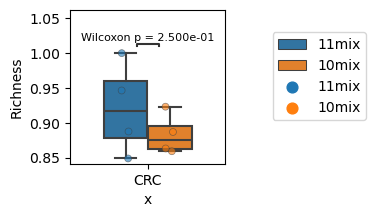

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2, 2))  #
g=sns.boxplot(data=metricsPS, x="x",y="Richness", hue= "condition")
sns.stripplot(data=metricsPS, x="x", y="Richness", hue="condition", dodge=True, 
              jitter=True, alpha=0.6, marker="o", edgecolor="gray", linewidth=0.5)

g.legend(loc='upper left', bbox_to_anchor=(1.26, 0.9))
g.set_ylabel("Richness")
#annotator = Annotator(data=metricsPS, ax=g, pairs=[(("CRC","11mix"),("CRC","10mix")) ],  x="x", y="Richness", hue= "condition")
#annotator.configure(test='Mann-Whitney-gt', text_format='full', loc='inside')
#annotator.apply_and_annotate()
add_stat_annotation(g, data=metricsPS, x="x", y="Richness", hue="condition", width=0.4,
                    box_pairs=[(("CRC","11mix"),("CRC","10mix")) ],
                    test='Wilcoxon', text_format='full', loc='inside', verbose=0, comparisons_correction='bonferroni')

plt.setp(g.texts, fontsize=8)
g.grid(False)
plt.show()
g.figure.savefig("./figures/richness_11mix_vs_10mix_ifng.svg", bbox_inches="tight")
g.figure.savefig("./figures/richness_11mix_vs_10mix_ifng.png", bbox_inches="tight")
#g.figure.savefig(resultsDir+"/TCR_cd8_perPatient_richness.svg", bbox_inches="tight")